# TSST - Práctica 7: Predicción con redes LSTM

**Alicia Lozano Díez**

Jueves 10-24 de abril de 2025 / Viernes 11-25 de abril de 2025


## Objetivo

El objetivo de esta práctica es proporcionar una introducción al uso de redes neuronales recurrentes (RNN) y en particular, a las Long Short-Term Memory (LSTM) para el procesamiento de series temporales y su uso en predicción. Para ello, se dividirá en dos partes basadas en dos ejemplos de datos: predicción del número de pasajeros en una aerolínea, y el problema de detección de actividad de voz (Voice Activity Detection, VAD). Esta última incluirá además una introducción al procesamiento de señales de voz.

### Materiales

- Guión (.ipynb) de la práctica - Moodle
- Ejemplos de datos y etiquetas - Moodle
- Listas de entrenamiento y validación VAD - Moodle
- Scripts de descarga de datos - Moodle
- Datos y etiquetas de entrenamiento VAD * - One Drive (https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/EeHT_NXP56FLkKffjyOhfa8BqAy3EmIrMkBZ0wnyDAti1g?download=1)
- Datos y etiquetas de validación VAD * - One Drive (https://dauam-my.sharepoint.com/:u:/g/personal/alicia_lozano_uam_es/ESc5XzkpZ3ZBnGFQ6HWdn_UB38NHMOLTLtTcEE_b81Cylw?download=1)


**CUIDADO: Los datos proporcionados son de uso exclusivo para esta práctica. No tiene permiso para copiar, distribuir o utilizar el corpus para ningún otro propósito.**


# Parte 1: Predicción mediante LSTM del número de pasajeros de una aerolínea



## 1.1. Carga y visualización de los datos

Igual que hicimos en la práctica 5, vamos a descargar el fichero con los datos de la base de datos *AirPassengers.csv* de Moodle, que contiene los datos del número de pasajeros de una aerolínea para un período de tiempo.

A continuación, los cargamos en Google Colab y los visualizamos para comprobar que es el resultado esperado:

In [ ]:
# from google.colab import files
# uploaded = files.upload()

Text(0.5, 1.0, 'Serie temporal: Air Passengers')

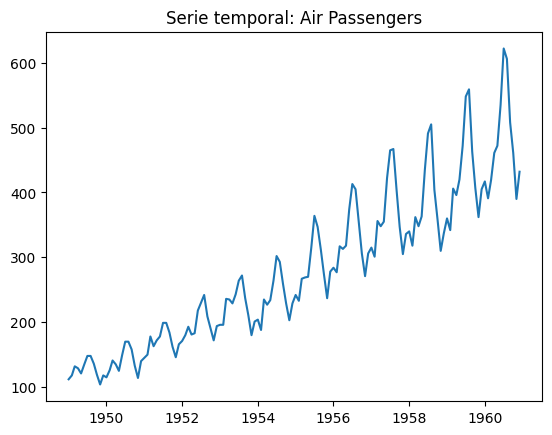

In [1]:
# Carga y visualizacion de los datos
from pandas import read_csv

data = read_csv('AirPassengers.csv', header=0, parse_dates=[0], index_col=0,
                date_format='%Y-%m')

from matplotlib import pyplot as plt
plt.plot(data)
plt.title('Serie temporal: Air Passengers')

## 1.2. Normalización o escalado

Las redes neuronales en general encuentran más dificultades para tratar con datos cuyos valores no tienen algún tipo de normalización.

Por ello, vamos a aplicar un escalado de los datos a valores entre 0 y 1 de la siguiente manera:

Text(0.5, 1.0, 'Serie temporal: Air Passengers (normalizada)')

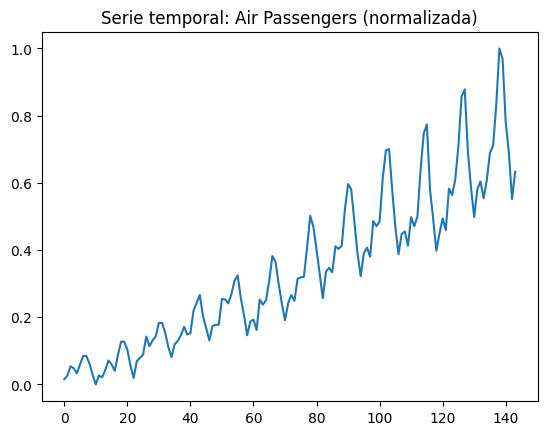

In [2]:
# 2. Normalización de los datos
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data)

plt.plot(data_norm)
plt.title('Serie temporal: Air Passengers (normalizada)')

## 1.3. Preparación de los datos y definición del modelo LSTM

Para el uso de modelos LSTM, vamos a utilizar la librería Pytorch (https://pytorch.org/docs/stable/index.html).

En particular, vamos a definir un modelo con un número de capas LSTM dadas, y una capa de salida _fully connected_:

In [3]:
# 4. Definición del modelo LSTM
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # Salida de la última capa LSTM
        hn = hn[-1]  # Seleccionamos el último estado oculto
        return self.fc(hn)

# Parámetros del modelo
input_size = 1
hidden_size = 20
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)


Como se observa, los parámetros utilizados serían los siguientes:

* Tamaño de la entrada a la capa LSTM: input_size
* Unidades (celdas) de la capa LSTM: hidden_size
* Unidades de salida: output_size (capa lineal)

Además, la red LSTM espera un tensor de entrada con el tamaño del batch, la longitud de la secuencia así como la dimensionalidad del espacio de características.

La función forward permite obtener la predicción de la salida para un dato (o batch) de entrada (realiza el paso forward del modelo).

**PREGUNTA 1: Revise la documentación de _torch.nn.LSTM_ y preste atención a los argumentos batch_first, bidirectional y dropout. ¿Para qué sirven dichos argumentos? ¿Cuál es por tanto la dimensionalidad del tensor de entrada esperado en el modelo anterior?**

Para preparar las secuencias para la red LSTM a partir de los datos, utilizamos el siguiente código, que además divide la serie temporal (nuestros datos) en un 80\% para entrenamiento y un 20\% para test (o validación).

In [4]:
# 3. Preparación de los datos en secuencias para LSTM
import numpy as np
import torch

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

seq_length = 12  # Ventana de 12 meses
data = data_norm.squeeze(-1)
X, y = create_sequences(data, seq_length)

# División de datos en entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Conversión a tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


**PREGUNTA 2: Compruebe que las dimensiones de los datos de entrada son las esperadas e indique qué es cada valor.**

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([105, 12]),
 torch.Size([105]),
 torch.Size([27, 12]),
 torch.Size([27]))

A continuación, definimos el resto de parámetros para realizar el entrenamiento del modelo, como son el optimizador, la función de coste y los demás hiperparámetros del entrenamiento.



In [6]:
# 5. Definición del optimizador y función de pérdida
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 6. Entrenamiento del modelo
epochs = 1000
batch_size = 32

**PREGUNTA 3: ¿Qué función de coste se optimiza? ¿Por qué? ¿Qué indica el valor de _batch_size_?**

Finalmente realizamos el entrenamiento del modelo durante las épocas indicadas.

In [ ]:
# 6. Entrenamiento del modelo

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].unsqueeze(-1)  # Añadimos dimensión extra
        y_batch = y_train[i:i+batch_size]

        # Forward
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")


**PREGUNTA 4: ¿Qué observa en la función de pérdida? ¿Tiene sentido? ¿Hacen falta más épocas?**

## 1.4. Evaluación del modelo - Predicción de nuevos datos

Una vez entrenado el modelo, realizamos la predicción sobre el conjunto de test (20\% restante de la serie):

In [ ]:
# 7. Predicción en el conjunto de prueba
from sklearn.metrics import mean_squared_error


model.eval()
X_test_unsqueezed = X_test.unsqueeze(-1)
predictions = model(X_test_unsqueezed).detach().numpy()

# Desescalado de las predicciones y los valores reales
y_test_descaled = scaler.inverse_transform(y_test.unsqueeze(-1).numpy())
predictions_descaled = scaler.inverse_transform(predictions)

# 8. Evaluación del modelo
mse = mean_squared_error(y_test_descaled, predictions_descaled)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")

# 9. Visualización de los resultados
plt.figure(figsize=(12, 6))
plt.plot(y_test_descaled, label='Valores reales', color='green')
plt.plot(predictions_descaled, label='Predicciones LSTM', color='red')
plt.title("Predicción del número de pasajeros con LSTM")
plt.xlabel("Índice de tiempo")
plt.ylabel("Número pasajeros")
plt.legend()
plt.show()


**PREGUNTA 5: Realice diferentes entrenamientos modificando los hiperparámetros y compare los resultados. ¿Tienen sentido?**

In [ ]:
# 7. Predicción en el conjunto de entrenamiento ("cheating")
from sklearn.metrics import mean_squared_error


model.eval()
X_train_unsqueezed = X_train.unsqueeze(-1)
predictions = model(X_train_unsqueezed).detach().numpy()

# Desescalado de las predicciones y los valores reales
y_train_descaled = scaler.inverse_transform(y_train.unsqueeze(-1).numpy())
predictions_descaled = scaler.inverse_transform(predictions)

# 8. Evaluación del modelo
mse = mean_squared_error(y_train_descaled, predictions_descaled)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")

# 9. Visualización de los resultados
plt.figure(figsize=(12, 6))
plt.plot(y_train_descaled, label='Valores reales', color='green')
plt.plot(predictions_descaled, label='Predicciones LSTM', color='red')
plt.title("Predicción del número de pasajeros con LSTM")
plt.xlabel("Índice de tiempo")
plt.ylabel("Número pasajeros")
plt.legend()
plt.show()

## 1.5. Aplicación a otros datos: series temporales financieras (opcional)

A continuación, podemos ampliar el trabajo elaborando un modelo basado en LSTM para los datos de series temporales financieras del S&P500 (usados en la práctica 5).

¿Hay diferencias a la hora de diseñar la red neuronal?

In [ ]:
## Ejercicio opcional: SP500



# Parte 2: Detección de actividad de voz (VAD)




## 2.1. Introducción al procesamiento de señales temporales de voz


### 2.1.1. Descarga de ficheros de ejemplo

Primero vamos a descargar el audio de ejemplo de Moodle (**audio_sample.wav**) y ejecutar las siguientes  líneas de código, que nos permitirán subir el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

Una vez cargado el fichero de audio, podemos escucharlo de la siguiente manera:

In [ ]:
import IPython

wav_file_name = "audio_sample.wav"
print(wav_file_name)
IPython.display.Audio(wav_file_name)

### 2.1.2. Lectura y representación de audio en Python

A continuación vamos a definir ciertas funciones para poder hacer manejo de  ficheros de audio en Python.

Comenzamos definiendo una función **read_recording** que leerá un fichero de audio WAV, normalizará la amplitud y devolverá el vector de muestras _signal_ y su frecuencia de muestreo _fs_.

In [ ]:
import scipy.io.wavfile

def read_recording(wav_file_name):
  fs, signal = scipy.io.wavfile.read(wav_file_name)
  signal = signal/max(abs(signal)) # normalizes amplitude

  return fs, signal


Si ejecutamos la función anterior para el fichero de ejemplo, podemos ver la forma en la que se carga dicho fichero de audio en Python. Así, podemos obtener la frecuencia de muestreo y la longitud del fichero en número de muestras:

In [ ]:
fs, signal = read_recording(wav_file_name)
print("Signal variable shape: " + str(signal.shape))
print("Sample rate: " + str(fs))
print("File length: " + str(len(signal)) + " samples")


**PREGUNTA 6: ¿Como obtendría la duración de la señal en segundos?**



In [ ]:
print("File length: " + str(len(signal)/fs) + " seconds")

También podemos representar la señal y ver su forma de onda. Para ello, definimos la función **plot_signal** como sigue:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signal(signal, fs, ylabel="", title=""):
  dur = len(signal)/fs
  step = 1./fs
  t_axis = np.arange(0., dur, step)

  plt.plot(t_axis, signal)
  plt.xlim([0, dur])
  plt.ylabel(ylabel)
  plt.xlabel('Time (seconds)')
  plt.title(title)
  plt.grid(True)


Y utilizando la función anterior, obtenemos su representación (amplitud frente al tiempo):

In [ ]:
plot_signal(signal, fs, "Amplitude", wav_file_name)
plt.show()

### 2.1.3. Representación de etiquetas de actividad de voz

En esta práctica, vamos a desarrollar un detector de actividad de voz, que determinará qué segmentos de la señal de voz son realmente voz y cuáles silencio.

Por ello, vamos a ver dos ejemplos de etiquetas _ground truth_, que corresponden al fichero de audio de ejemplo.

Primero, descargamos de Moodle las etiquetas de voz/silencio que están en los ficheros **audio_sample_labels_1.voz** y **audio_sample_labels_2.voz** y las cargamos en Google Colab como en el caso anterior.

In [ ]:
from google.colab import files
uploaded = files.upload()

Estas etiquetas están guardadas en ficheros de texto y podemos cargarlas en Python de la siguiente manera:

In [ ]:
labels_file_name = 'audio_sample_labels_1.voz'
voice_labels = np.loadtxt(labels_file_name)


Con el siguiente código, podemos representar la señal de voz así como sus etiquetas en la misma figura:

In [ ]:
plot_signal(signal, fs)
plot_signal(voice_labels*2-1, fs, "Amplitude", wav_file_name)
plt.show()

Las etiquetas de voz/silencio provienen de distintos detectores de actividad de voz.

**PREGUNTA 7:**
- **¿Qué valores tienen las etiquetas? ¿Qué significan dichos valores?**
- **¿Por qué se representa _voice_labels*2-1_?**
- **Represente la señal de voz junto con las etiquetas para ambos casos. ¿Qué diferencias observas? ¿A qué se puede deber?**
- **¿Qué cantidad de voz/silencio hay en cada etiquetado?**

### 2.1.4. Extracción de características

En la mayoría de sistemas de reconocimiento de patrones, un primer paso es la extracción de características. Esto consiste, a grandes rasgos, en obtener una representación de los datos de entrada, que serán utilizados para un posterior modelado.

En nuestro caso, vamos pasar de la señal en crudo _"raw"_ dada por las muestras (_signal_), a una secuencia de vectores de características que extraigan información a corto plazo de la misma y la representen. Esta sería la entrada a nuestro sistema de detección de voz basado en redes neuronales.

Para ver algunos ejemplos, vamos a utilizar la librería _librosa_ (https://librosa.org/doc/latest/index.html).

Dentro de esta librería, tenemos funciones para extraer distintos tipos de características de la señal de voz, como por ejemplo el espectrograma en escala Mel (_melspectrogram_).

Estas características a corto plazo, se extraen en ventanas de unos pocos milisegundos con o sin solapamiento.

Un ejemplo sería el siguiente:


In [ ]:
import librosa

mel_spec = librosa.feature.melspectrogram(y=signal,sr=fs,n_mels=23,win_length=320,hop_length=160)

print(mel_spec.shape)
print(signal.shape)

**PREGUNTA 8:**
- **¿Qué se obtiene de la función anterior?**
- **¿Qué significan los valores de los parámetros _win_length_ y _hop_length_?**
- **¿Qué dimensiones de _mel_spec_ obtienes? ¿Qué significan?**

De esta manera, podríamos obtener una parametrización de las señales para ser utilizadas como entrada a nuestra red neuronal.

Para los siguientes apartados, se proporcionan los vectores de características MFCC para una serie de audios que se utilizarán como conjunto de entrenamiento del modelo de VAD.

## 2.2. Detector de actividad de voz (Voice Activity Detector, VAD)



### 2.2.1. Descarga de los datos de entrenamiento

Primero vamos a descargar la lista de identificadores de los datos de entrenamiento de la práctica.

Para ello, necesitaremos descargar de Moodle el fichero **training_VAD.lst**, y ejecutar las siguientes líneas de código, que nos permitirán cargar el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

A continuación cargamos los identificadores contenidos en el fichero en una lista en Python:

In [ ]:
file_train_list = 'training_VAD.lst' # mat files containing data + labels
f = open(file_train_list, 'r')
train_list = f.read().splitlines()
f.close()

Podemos ver algunos de ellos (los primeros 10 identificatores) de la siguiente forma:

In [ ]:
print(train_list[:10])

Ahora, descargaremos de Moodle el fichero **data_download_onedrive_training_VAD.sh**, y ejecutaremos las siguientes líneas de código, que nos permitirán cargar el archivo a Google Colab desde el disco local:

In [ ]:
from google.colab import files
uploaded = files.upload()

Para descargar el conjunto de datos desde One drive, ejecutamos el script cargado anteriormente de la siguiente manera:

In [ ]:
!chmod 755 data_download_onedrive_training_VAD.sh
!./data_download_onedrive_training_VAD.sh

Este script descargará los datos de One Drive y los cargará en Google Colab, descomprimiéndolos en la carpeta **data/training_VAD**.

Podemos comprobar que los ficheros **.mat** se encuentran en el directorio esperado:


In [ ]:
!ls data/training_VAD/ | head

### 2.2.2. Definición del modelo

Utilizando nuevamente la librería Pytorch, vamos a definir un modelo inicial con una capa LSTM y una capa de salida. La capa de salida estará formada por una única neurona. La salida indicará la probabilidad de voz/silencio utilizando una función *sigmoid*.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model_1(nn.Module):
    def __init__(self, feat_dim=20):
        super(Model_1, self).__init__()

        self.lstm = nn.LSTM(feat_dim,256,batch_first=True,bidirectional=False)
        self.output = nn.Linear(256,1)

    def forward(self, x):

        out = self.lstm(x)[0]
        out = self.output(out)
        out = torch.sigmoid(out)

        return out.squeeze(-1)

**PREGUNTA 9: En este modelo, estamos utilizando una única neurona a la salida. ¿Hay alguna otra alternativa? ¿Se seguiría utilizando una función _sigmoid_?**

Una vez definida la clase, podemos crear nuestra instancia del modelo y cargarlo en la GPU con el siguiente código:

In [ ]:
model = Model_1(feat_dim=20)
model = model.to(torch.device("cuda"))
print(model)

Nuestra variable _model_ contiene el modelo, y ya estamos listos para entrenarlo y evaluarlo.

### 2.2.3. Lectura y preparación de los datos para el entrenamiento

Como hemos visto anteriormente, nuestros datos están guardados en ficheros de Matlab (**.mat**). Cada uno de estos ficheros contiene una matriz **X** correspondiente a las secuencias de características MFCC (con sus derivadas de primer y segundo orden), y un vector **Y** con las etiquetas de voz/silencio correspondientes.

Veamos un ejemplo:


In [ ]:
features_file = 'data/training_VAD/features_labs_1.mat'

import scipy.io
features = scipy.io.loadmat(features_file)['X']
labels = scipy.io.loadmat(features_file)['Y']

print(features.shape)
print(labels.shape)


Elija un fichero de entrenamiento y observe tanto el tamaño de **features** como de **labels**. Estas dimensiones se corresponden con la dimensionalidad de las características (20 coeficientes MFCC en nuestro caso) y la otra dimensión es la longitud de la secuencia en número de ventanas o frames.

El entrenamiento del modelo se va a realizar mediante descenso por gradiente (o alguna de sus variantes) basado en _batches_.

Para preparar cada uno de estos _batches_ que servirán de entrada a nuestro modelo LSTM, debemos almacenar las características en secuencias de la misma longitud. El siguiente código lee las características (**get_fea**) y sus correspondientes etiquetas (**get_lab**) de un fragmento aleatorio del fichero de entrada.

In [ ]:
import scipy.io
import numpy as np

def get_fea(segment, rand_idx):
    data = scipy.io.loadmat(segment)['X']
    if data.shape[0] <= length_segments:
        start_frame = 0
    else:
        start_frame = np.random.permutation(data.shape[0]-length_segments)[0]

    end_frame = np.min((start_frame + length_segments,data.shape[0]))
    rand_idx[segment] = start_frame
    feat = data[start_frame:end_frame,:]
    return feat[np.newaxis, :, :]


def get_lab(segment, rand_idx):
    data = scipy.io.loadmat(segment)['Y']
    start_frame = rand_idx[segment]
    end_frame = np.min((start_frame + length_segments, data.shape[0]))
    labs = data[start_frame:end_frame].flatten()
    return labs[np.newaxis,:]

**PREGUNTA 10: Analice las funciones anteriores detenidamente. ¿De qué tamaño son los fragmentos que se están leyendo? ¿Para qué sirve _rand_idx_?**

### 2.2.4. Entrenamiento del modelo
Una vez definidas las funciones de lectura de datos y preparación del formato que necesitamos para la entrada a la red LSTM, podemos utilizar el siguiente código para entrenarlo.

In [ ]:
length_segments = 300
path_in_feat = 'data/training_VAD/'

from torch import optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 51
segment_sets = np.array_split(train_list, len(train_list)/batch_size)

max_iters = 5
for epoch in range(1, max_iters):
  print('Epoch: ',epoch)
  model.train()
  cache_loss = 0
  num_correct = 0
  num_total = 0

  for ii, segment_set in enumerate(segment_sets):
    rand_idx = {}
    optimizer.zero_grad()

    # Create training batches
    train_batch = np.vstack([get_fea(path_in_feat + segment, rand_idx) for segment in segment_set])
    labs_batch = np.vstack([get_lab(path_in_feat + segment, rand_idx).astype(np.int16)  for segment in segment_set])
    assert len(labs_batch) == len(train_batch) # make sure that all frames have defined label
    # Shuffle the data and place them into Pytorch tensors
    shuffle = np.random.permutation(len(labs_batch))
    labs_batch = torch.tensor(labs_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cuda"))
    train_batch = torch.tensor(train_batch.take(shuffle, axis=0).astype("float32")).to(torch.device("cuda"))

    # Forward the data through the network
    outputs = model(train_batch)

    # Compute cost
    loss = criterion(outputs, labs_batch)

    # Backward step
    loss.backward()
    optimizer.step()
    cache_loss += loss.item()

    # Estimate the number of correct outputs (acc)
    num_correct += (outputs.round()).eq(labs_batch).sum().item()
    num_total += (train_batch.size()[0]*train_batch.size()[1])
    acc = num_correct * 1.0 / num_total

  print("Loss / accuracy: " + str(cache_loss/len(train_batch)) + '/' + str(acc))


**PREGUNTA 11:**
**Analizar el código anterior cuidadosamente y ejecutarlo. A continuación, responder a las siguientes cuestiones:**
- **¿Qué función de coste se está optimizando? Describir brevemente con ayuda de la documentación.**
- **¿Qué optimizador se ha definido?**
- **¿Para qué se utiliza _batch_size_?**
- **Describir brevemente la creación de los _batches_.**
- **¿Qué línea de código realiza el _forward pass_?**
- **¿Qué línea de código realiza el _backward pass_?**
- **¿Cuántas iteraciones del algoritmo ha realizado? ¿Qué observa en la evolución de la función de coste?**
- **Añada al código el cálculo de la precisión o _accuracy_, de tal manera que se muestre por pantalla dicho valor en cada iteración (similar a lo que ocurre con el valor del coste _loss_). Copiar el código en el informe y describir brevemente.**
- **¿Qué valor de coste y _accuracy_ obtiene? ¿Cómo se puede mejorar?**

### 2.2.5. Evaluación del modelo: un único fichero de test

Una vez entrenado el modelo, vamos a evaluarlo en un ejemplo en concreto.

Descargue de Moodle el fichero **audio_sample_test.wav**, con sus correspondientes características y etiquetas **audio_sample_test.mat** y evalúe el rendimiento en el mismo, observando por ejemplo el _accuracy_ obtenido.


In [ ]:
# Código de evaluación aquí



A continuación, represente 10 segundos de dicho audio, así como sus etiquetas de _ground_truth_ y las obtenidas con su modelo.

**PREGUNTA 12: Visualmente, ¿es bueno el modelo?**
**También puede escuchar el audio para evaluarlo cualitativamente.**


In [ ]:
# Representación 10 segundos + etiquetas estimadas

### 2.2.6. Evaluación del modelo: conjunto de validación





Ahora vamos a evaluar el rendimiento del modelo anterior sobre un conjunto de validación (del que conocemos sus etiquetas).

Para este conjunto de datos, descargaremos la lista de identificadores **valid_VAD.lst** de Moodle, así como el fichero de descarga de datos **data_download_onedrive_valid_VAD.sh**:

In [ ]:
from google.colab import files
uploaded = files.upload()

!chmod 755 data_download_onedrive_valid_VAD.sh
!./data_download_onedrive_valid_VAD.sh

Escriba ahora el código necesario para evaluar el modelo anterior en el conjunto de datos de validación, para su última época.

Tenga en cuenta que si quiere realizar el forward para todos los datos de validación de una vez, necesitará que todas las secuencias sean de la misma longitud. Como aproximación, puede escoger unos pocos segundos de cada fichero como se hace en el entrenamiento.

In [ ]:
# INSERTE SU CÓDIGO AQUÍ


**PREGUNTA 13: ¿Qué rendimiento (loss y accuracy) obtiene con este modelo (_Model_1_) en entrenamiento y en validación?**

## 2.3. Comparación de modelos



### 2.3.1. Redes LSTM bidireccionales

En este apartado, vamos a partir del modelo inicial (_Model_1_) y modificarlo para que la capa LSTM sea bidireccional (_Model_1B_).

Entrene el nuevo modelo y compare el resultado con el modelo inicial.

In [ ]:
# INSERTE SU CÓDIGO AQUÍ

**PREGUNTA 14:**
- **Explique brevemente la diferencia entre una capa LSTM y una BLSTM (bidirectional LSTM).**
- **¿Qué modelo obtiene un mejor resultado sobre los datos de validación? ¿Por qué puede ocurrir esto?**

### 2.3.2. Modelo "más profundo"

En este apartado, vamos a partir nuevamente del modelo _Model_1_ y vamos a añadir una segunda capa LSTM tras la primera, con el mismo tamaño y configuración, definiendo un nuevo modelo _Model_2_.

Entrénelo y compare los resultados.

In [ ]:
# INSERTE SU CÓDIGO AQUÍ

**PREGUNTA 15:**
- **¿Qué modelo obtiene un mejor resultado sobre los datos de validación, _Model_1_ o _Model_2_? ¿Por qué puede ocurrir esto?**
- **Y con respecto a _Model_1B_, ¿cuál es mejor?**